# <p align=center> Réalisez une étude de santé publique avec R ou Python <p>

Vous avez récemment rejoint une équipe de chercheurs de la Food and Agriculture Organization of the United Nations (FAO), en tant que data analyst.

<p align=center><img src="https://s41721.pcdn.co/wp-content/uploads/2022/05/FAO_logo_Blue_3lines_en.png" alt="Logo FAO" title=""><p>


Son rôle ? C’est l’un des organes qui composent l’ONU et dont l’objectif est « d’aider à construire un monde libéré de la faim ». 

Le responsable de l’équipe, Marc, un chercheur en économie de la santé, est particulièrement enthousiaste à l’idée de votre arrivée au sein de son équipe. En effet, ce recrutement tombe à pic car Julien, l'ancien data analyst, a récemment été muté dans une autre équipe, et la vôtre vient de se voir confier la mission de réaliser une étude de grande ampleur sur le thème de la sous-nutrition dans le monde.
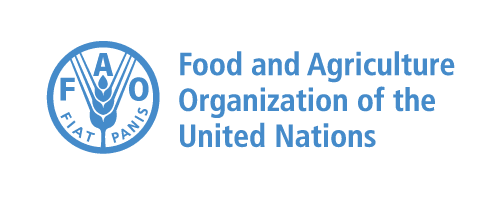

# SOMMAIRE<br> <a class="anchor" id="sommaire"></a>

- __[1. Préparation des données](#1-préparation-des-données)__<br>
   - [1.1. Nettoyage - Aide Alimentaire](#11-nettoyage---aide-alimentaire)<br>
   - [1.2. Nettoyage - Population](#12-nettoyage---population)<br>
   - [1.3. Nettoyage - Dispo_alimentaire](#13-nettoyage---dispo_alimentaire)<br>
   - [1.4. Nettoyage - Sous_nutrition](#14-nettoyage---sous_nutrition)<br>
- __[2. Analyse des données](#2-analyse)__<br>
   - [2.1. Demandes de Marc](#21-demandes-de-marc)<br>
   - [2.2. Demandes de Julien](#22-demandes-de-julien)<br>
   - [2.3. Demandes de Mélanie](#23-demandes-de-melanie)<br>


## 1. Préparation des données <a class="anchor" id="1-préparation-des-données">


Import des librairies nécessaires <br>
Définition des valeurs de références

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
#Choix de l'année de référence
annee = 2017

Il faut nettoyer les données et rétaplir la cohérance des informations :
- dispo / aide ==> Mettre les quantités en milliers de tonnes
- insécu / pop ==> Mettre le nombre d'habitants en millions

### 1.1. Nettoyage - Aide alimentaire <a class="anchor" id="Nettoyage_Aide_alimentaire"></a>

In [2]:
#Import du csv
aide = pd.read_csv('aide_alimentaire.csv')
#Changement des libellés de colonnes
aide.rename(columns={"Valeur":"Quantité"}, inplace=True)
aide.rename(columns={"Pays bénéficiaire":"Pays"}, inplace=True)
#Remplacer les NaN par des 0
aide = aide.fillna(0)
# Conversion de la Quantité en millers de tonnes
aide['Quantité'] = aide['Quantité'] / 1e3


Retour au [sommaire](#sommaire)

### 1.2. Nettoyage - Population <a class="anchor" id="Nettoyage_population"></a>

In [3]:
#Import du csv
pop = pd.read_csv('population.csv')
#Changement des libellés de colonnes
pop.rename(columns={"Valeur":"Population"}, inplace=True)
pop.rename(columns={"Zone":"Pays"}, inplace=True)
# Mise de la population en million d'habitants
pop['Population'] = pop['Population'] / 1e3


Retour au [sommaire](#sommaire)

### 1.3 Nettoyage - Dispo_alimentaire

In [4]:
#Import du csv
dispo = pd.read_csv('dispo_alimentaire.csv')
#Changement des libellés de colonnes
dispo.rename(columns={"Zone":"Pays"}, inplace=True)
#Remplacer les NaN par des 0
dispo = dispo.fillna(0)


Retour au [sommaire](#sommaire)

### 1.4. Nettoyage - Sous_nutrition

In [5]:
#Import du csv
sous_nut = pd.read_csv('sous_nutrition.csv')
#Changement des libellés de colonnes
sous_nut.rename(columns={"Valeur":"Population sousnut"}, inplace=True)
sous_nut.rename(columns={"Zone":"Pays"}, inplace=True)
#Transformation de l'année pour avoir une valeur exploitalbe
sous_nut[['Début','Fin']] = sous_nut['Année'].str.split('-', expand=True)

var_modif = ['Début', 'Fin']
for var in  var_modif:
    sous_nut[var] = sous_nut[var].astype("int")

sous_nut['Année de Référence'] = (sous_nut['Début'] + sous_nut ['Fin']) /2
sous_nut['Année de Référence'] = sous_nut['Année de Référence'].astype('int')

#Correction de la donnée population
sous_nut.loc[sous_nut['Population sousnut'] == '<0.1', 'Population sousnut'] = 0
sous_nut['Population sousnut'] = sous_nut['Population sousnut'].astype(float)



Retour au [sommaire](#sommaire)

## 2. Analyse des données

### 2.1. Demandes de Marc

#### __Calcul de la proportion de personnes en état de sous-nutrition pour l'année 2017__

In [6]:
pop_mondiale = pop.loc[pop['Année']==annee, 'Population'].sum()*1e6

sous_nut_mondiale = sous_nut.loc[sous_nut['Année de Référence']==annee, 'Population sousnut'].sum()*1e6

ratio_sous_nut = sous_nut_mondiale / pop_mondiale * 100

print(f"En {annee}, la population mondiale est de {round(pop_mondiale)} personnes. Le nombre de personnes en état de sous nutrition est alors de {round(sous_nut_mondiale)}.")
print(f"Le taux de sous-nutrition mondiale en {annee} est de {ratio_sous_nut.round(1)} %.")

En 2017, la population mondiale est de 7548134111 personnes. Le nombre de personnes en état de sous nutrition est alors de 535700000.
Le taux de sous-nutrition mondiale en 2017 est de 7.1 %.


#### __Disponibilité aliementaire mondiale__

D'après la FAO, le minimum requis en apport calorique par jour est de 2200 kcal [(source)](#https://www.fao.org/3/y3951f/y3951f04.htm).<br>
La consommation moyenne journalière d'un homme est de 2500 kcal. <br>
Combien peut-on nourrire d'individus avec la disponibilité alimentaire mondiale ?


In [7]:
besoin_kcal_minimum = 2200
besoin_kcal_homme = 2500
#Récuperation de la population mondiale en 2017
pop_annee = pop.loc[pop["Année"] == annee]

# Merge Pop 2017 et dispo 
dispo_mondiale = pd.merge(pop_annee, dispo, on = 'Pays', how = 'right')

dim = (dispo_mondiale['Disponibilité alimentaire (Kcal/personne/jour)']*dispo_mondiale['Population']*1e6*365).sum()
pop_nourrie_max = (dispo_mondiale['Disponibilité alimentaire (Kcal/personne/jour)']*dispo_mondiale['Population']*1e6).sum() /besoin_kcal_minimum
pop_nourrie = (dispo_mondiale['Disponibilité alimentaire (Kcal/personne/jour)']*dispo_mondiale['Population']*1e6).sum() /besoin_kcal_homme

print(f"La disponibilité alimentaire mondiale est de {dim} kcal pour l'année {annee}.")
print(f"Avec cette disponibilité, pour un minimum d'apport calorique journalier de {besoin_kcal_minimum} kcal/jour, la Terre pourrait théoriquement nourrir {round(pop_nourrie_max)} humains, \
soit environ {round(pop_nourrie_max/1e9, 3)} milliards de personnes. Cela correspont à {round(pop_nourrie_max/pop_mondiale*100 , 2)}% de la population.")
print(f"Si on considère l'apport journalier d'un homme, soit {besoin_kcal_homme} kcal/jour, la disponibilité alimentaire permettrait de nourrir {round(pop_nourrie/1e9, 3)} milliards de personnes, \
c'est-à-dire {round(pop_nourrie/pop_mondiale*100 , 2)}% de la population.")


La disponibilité alimentaire mondiale est de 7635429388975815.0 kcal pour l'année 2017.
Avec cette disponibilité, pour un minimum d'apport calorique journalier de 2200 kcal/jour, la Terre pourrait théoriquement nourrir 9508629376 humains, soit environ 9.509 milliards de personnes. Cela correspont à 125.97% de la population.
Si on considère l'apport journalier d'un homme, soit 2500 kcal/jour, la disponibilité alimentaire permettrait de nourrir 8.368 milliards de personnes, c'est-à-dire 110.86% de la population.


>__Concernant la production végétale__

In [8]:
dispo_vege = dispo_mondiale.loc[dispo['Origine']=='vegetale']
pop_nourrie_max_vege = (dispo_vege['Disponibilité alimentaire (Kcal/personne/jour)']*dispo_vege['Population']*1e6).sum() /besoin_kcal_minimum
pop_nourrie_vege = (dispo_vege['Disponibilité alimentaire (Kcal/personne/jour)']*dispo_vege['Population']*1e6).sum() /besoin_kcal_homme
divg = (dispo_vege['Disponibilité alimentaire (Kcal/personne/jour)']*dispo_vege['Population']*1e6*365).sum()

print(f"La disponibilité intérieure mondiale en végétaux est de {divg} kcal pour l'année {annee}.")
print(f"Concernant uniquement les végétaux, pour un minimum d'apport calorique journalier de {round(besoin_kcal_minimum,0)} kcal/jour, la Terre pourrait théoriquement nourrir {round(pop_nourrie_max_vege,3)} humains, \
soit environ {round(pop_nourrie_max_vege/1e9,3)} milliards de personnes, soit {round(pop_nourrie_max_vege/pop_mondiale*100)}% de la population.")
print(f"Si on considère l'apport journalier d'un homme, soit {besoin_kcal_homme} kcal/jour, la disponibilité alimentaire permettrait de nourrir {round(pop_nourrie_vege/1e9 , 3)} milliards de personnes, \
c'est-à-dire {round(pop_nourrie_vege/pop_mondiale*100 , 2)}% de la population.")


La disponibilité intérieure mondiale en végétaux est de 6300178937197865.0 kcal pour l'année 2017.
Concernant uniquement les végétaux, pour un minimum d'apport calorique journalier de 2200 kcal/jour, la Terre pourrait théoriquement nourrir 7845801914.319 humains, soit environ 7.846 milliards de personnes, soit 104% de la population.
Si on considère l'apport journalier d'un homme, soit 2500 kcal/jour, la disponibilité alimentaire permettrait de nourrir 6.904 milliards de personnes, c'est-à-dire 91.47% de la population.


#### __Utilisation de la disponibilité interieure mondiale__

>__Disponibilité interieure utilisée pour l'alimentation animale__

In [9]:
di_al_animaux = dispo['Aliments pour animaux'].sum()
di = dispo['Disponibilité intérieure'].sum()

print(f"L'alimenation animale représente {round(di_al_animaux/di * 100 , 2)}% de la disponibilité interieure mondiale.")

L'alimenation animale représente 13.24% de la disponibilité interieure mondiale.


>__Disponibilité interieure perdue__

In [10]:
di_pertes = dispo['Pertes'].sum()

print(f"{round(di_pertes/di * 100 , 2)}% de la disponibilité interieure mondiale est perdue.")

4.61% de la disponibilité interieure mondiale est perdue.


>__Disponibilité intérieure utilisée pour l'alimenation humaine__

In [11]:
di_alimentation_humaine = dispo['Nourriture'].sum()

print(f"{round(di_alimentation_humaine/di * 100 , 2)}% de la disponibilité interieure mondiale sert à l'alimentation humaine.")

49.51% de la disponibilité interieure mondiale sert à l'alimentation humaine.


Retour au [sommaire](#sommaire)

### 2.2 Demandes de Julien

#### __2 façons de calculer la disponibilité intérieure__

In [12]:
#Calcul de la disponibilité intérieur
dispo['DI1'] = dispo['Production'] + dispo['Importations - Quantité'] - dispo['Exportations - Quantité'] + dispo['Variation de stock']
dispo['DI2'] = dispo['Aliments pour animaux'] + dispo['Autres Utilisations']+ dispo['Nourriture'] + dispo['Pertes']+ dispo['Semences']+dispo['Traitement']

In [13]:
di1 = dispo['DI1'].sum()
di2 = dispo['DI2'].sum()
print(f"Avec la première methode, l'écart est de {round((di1-di)/(di+di1)*100,4)}%.")
print(f"Avec la deuxième methode, l'écart est de {round((di2-di)/(di+di2)*100,4)}%.")

Avec la première methode, l'écart est de 0.0009%.
Avec la deuxième methode, l'écart est de 0.0487%.


#### __Utilisation des céréales__

In [14]:
cereales = ['Avoine','Blé','Céréales, Autres','Maïs','Millet','Orge','Riz (Eq Blanchi)','Seigle','Sorgho']
#Selection des colonnes numériques
dispo_cereales = dispo[['Produit','Aliments pour animaux', 'Autres Utilisations', 'Disponibilité intérieure', 'Exportations - Quantité', 'Importations - Quantité', 'Nourriture','Pertes', 'Production','Semences','Traitement','Variation de stock']]
#Somme par catégorie de produit
dispo_cereales = dispo_cereales.groupby('Produit').sum().reset_index()
analyse_cereale = dispo_cereales[dispo_cereales['Produit'].isin(cereales)].copy()

analyse_cereale['Différence'] = round((analyse_cereale['Nourriture'] - analyse_cereale['Aliments pour animaux']),2)
analyse_cereale[['Produit', 'Aliments pour animaux', 'Nourriture', 'Différence']].sort_values('Différence')


,Produit,Aliments pour animaux,Nourriture,Différence
52,Maïs,546116.0,125184.0,-420932.0
62,Orge,92658.0,6794.0,-85864.0
21,"Céréales, Autres",19035.0,5324.0,-13711.0
7,Avoine,16251.0,3903.0,-12348.0
80,Seigle,8099.0,5502.0,-2597.0
82,Sorgho,24808.0,24153.0,-655.0
54,Millet,3306.0,23040.0,19734.0
12,Blé,129668.0,457824.0,328156.0
79,Riz (Eq Blanchi),33594.0,377286.0,343692.0


In [15]:
print(f"La disponibilité intérieure mondiale des céréales {*cereales,}  est de {round(analyse_cereale['Disponibilité intérieure'].sum()/1e3,2)} millions de tonnes.")
print(f"La production mondiale des céréales listés ci-dessus est de {round(analyse_cereale['Production'].sum(),2)} milliers de tonnes.")
print(f"{round((analyse_cereale['Aliments pour animaux'].sum())/(analyse_cereale['Disponibilité intérieure'].sum())*100,2)}% de la disponibilité intérieure sert à l'alimentation animale.")
print(f"{round((analyse_cereale['Nourriture'].sum())/(analyse_cereale['Disponibilité intérieure'].sum())*100,2)}% de la disponibilité intérieure sert à l'alimentation humaine.")
print(f"{round((analyse_cereale['Pertes'].sum())/(analyse_cereale['Disponibilité intérieure'].sum())*100,2)}% de la disponibilité intérieure est perdue.")
print(f"{round((analyse_cereale['Semences'].sum())/(analyse_cereale['Disponibilité intérieure'].sum())*100,2)}% de la disponibilité intérieure est utilisée comme semences.")

La disponibilité intérieure mondiale des céréales ('Avoine', 'Blé', 'Céréales, Autres', 'Maïs', 'Millet', 'Orge', 'Riz (Eq Blanchi)', 'Seigle', 'Sorgho')  est de 2407.0 millions de tonnes.
La production mondiale des céréales listés ci-dessus est de 2523345.0 milliers de tonnes.
36.29% de la disponibilité intérieure sert à l'alimentation animale.
42.75% de la disponibilité intérieure sert à l'alimentation humaine.
4.45% de la disponibilité intérieure est perdue.
2.85% de la disponibilité intérieure est utilisée comme semences.


>_Analyse graphique de l'utilisation des différents types de céréales_

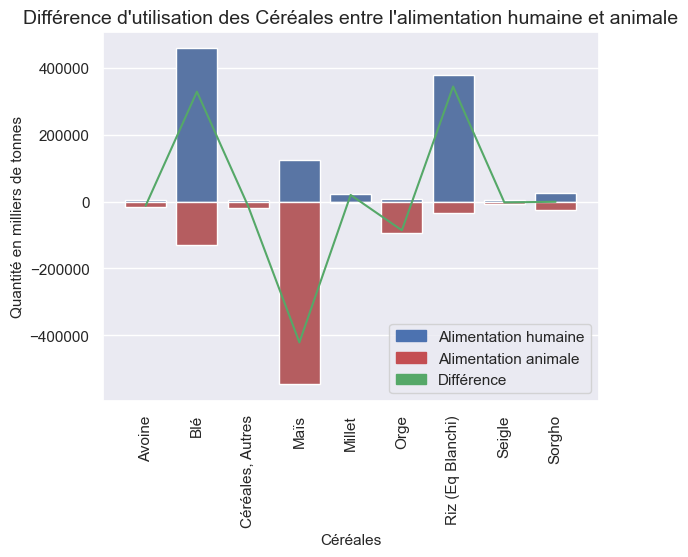

In [16]:
#Aliments pour animaux en négatif pour faciliter la visualisation
analyse_cereale['Aliments pour animaux2']=analyse_cereale['Aliments pour animaux']*(-1)

#Création de 2 histogramme négatifs et positifs
sns.barplot(x= 'Produit', y = 'Nourriture', data = analyse_cereale, color="b")
sns.barplot(x= 'Produit', y = 'Aliments pour animaux2', data = analyse_cereale , color="r")
#Creation de la légende
ac_a = mpatches.Patch(color='b', label='Alimentation humaine')
ac_b = mpatches.Patch(color='r', label='Alimentation animale')
ac_c = mpatches.Patch(color='g', label='Différence')
plt.legend(handles=[ac_a,ac_b,ac_c])
#Création de la courbe matérialisant la différence
bx = sns.lineplot(x= 'Produit', y = 'Différence' , data = analyse_cereale, color = "g")
#Rotation des libélés X
bx.set_xticklabels(bx.get_xticklabels(),rotation = 90)
#Noms des axes
plt.xlabel("Céréales" , fontsize = 11)
plt.ylabel("Quantité en milliers de tonnes", fontsize = 11)
plt.title("Différence d'utilisation des Céréales entre l'alimentation humaine et animale" , fontsize = 14)

plt.show()

__Cas du Manioc en Thaïlande__

In [17]:
pays = 'Thaïlande'
produit = 'Manioc'

dispo_spe = dispo.loc[(dispo['Pays'] ==pays)&(dispo['Produit'] == produit),['Pays','Produit','Disponibilité intérieure', 'Production', 'Exportations - Quantité', 'Nourriture', 'Aliments pour animaux','Importations - Quantité']].reset_index().copy()
dispo_spe_prod = dispo_spe.iloc[0,4]
dispo_spe_exp = dispo_spe.iloc[0,5]
dispo_spe_nourriture = dispo_spe.iloc[0,6]
dispo_spe_animaux = dispo_spe.iloc[0,7]

sous_nut_spe = sous_nut.loc[(sous_nut['Pays'] == pays)&(sous_nut['Année de Référence']==annee)]
sous_nut_spe = sous_nut_spe.iloc[0,2]

pop_spe = pop_annee.loc[pop_annee['Pays']== pays].iloc[0,2]


In [18]:
print(f"En {annee}, la production de {produit} par la {pays} est de {round(dispo_spe_prod)} millers de tonnes. \
{round(dispo_spe_exp/dispo_spe_prod*100,2)}% de cette production est exportée, {round(dispo_spe_animaux/dispo_spe_prod*100,2)}% sert d'alimentation animale.")
print(f"Seule {round(dispo_spe_nourriture/dispo_spe_prod*100,2)} % sert à l'alimentation humaine.")
print(f"Pourtant, la {pays} a {sous_nut_spe} millions d'habitants en état de sous nutrition, soit {round(sous_nut_spe/pop_spe*100 , 2)}% de sa population.")

En 2017, la production de Manioc par la Thaïlande est de 30228 millers de tonnes. 83.41% de cette production est exportée, 5.95% sert d'alimentation animale.
Seule 2.88 % sert à l'alimentation humaine.
Pourtant, la Thaïlande a 6.2 millions d'habitants en état de sous nutrition, soit 8.96% de sa population.


Retour au [sommaire](#sommaire)

### 2.3 Demandes de Melanie

#### __Pays pour lesquels la proportion de personnes sous-alimentées est la plus forte en 2017__

In [19]:
#Création d'une PK pour liaison des 2 DF
sous_nut['Ref'] = sous_nut['Pays'] + sous_nut['Année de Référence'].astype('string')
pop['Ref'] = pop['Pays'] + pop['Année'].astype('string')
#Liaison
analyse_sous_nut = pd.merge(sous_nut, pop, on = 'Ref' , how = 'left')
analyse_sous_nut['Proportion en %'] = round(analyse_sous_nut['Population sousnut'] / analyse_sous_nut['Population'] * 100 , 2)
proportion_sous_nut = analyse_sous_nut.loc[(analyse_sous_nut['Année de Référence']==annee)&(analyse_sous_nut['Proportion en %']>19.5), ['Pays_x', 'Population sousnut', 'Population' , 'Proportion en %']].sort_values('Proportion en %', ascending= False).reset_index(drop=True)
proportion_sous_nut.head(20)


,Pays_x,Population sousnut,Population,Proportion en %
0,Haïti,5.3,10.982366,48.26
1,République populaire démocratique de Corée,12.0,25.429825,47.19
2,Madagascar,10.5,25.570512,41.06
3,Libéria,1.8,4.702226,38.28
4,Lesotho,0.8,2.091534,38.25
5,Tchad,5.7,15.016753,37.96
6,Rwanda,4.2,11.980961,35.06
7,Mozambique,9.4,28.649018,32.81
8,Timor-Leste,0.4,1.243258,32.17
9,Afghanistan,10.5,36.296113,28.93


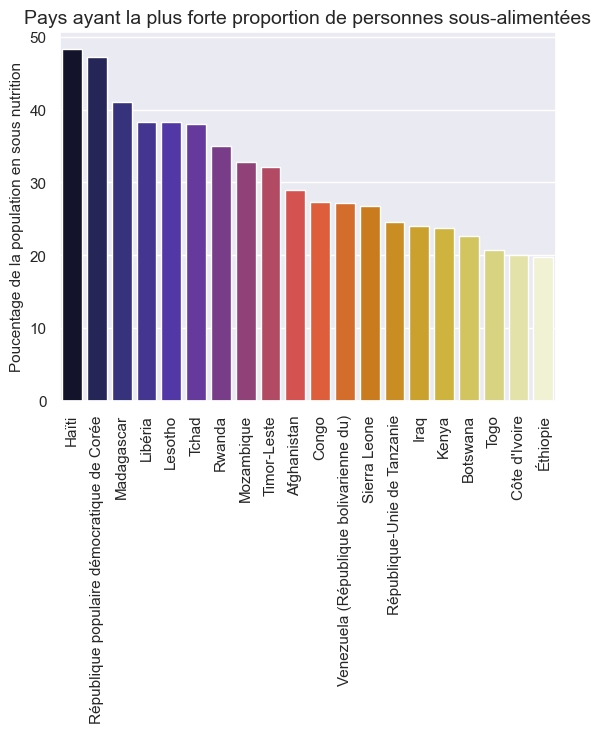

In [20]:
ax = sns.barplot(x = proportion_sous_nut['Pays_x'], y = proportion_sous_nut['Proportion en %'], data = proportion_sous_nut['Proportion en %'], palette="CMRmap")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.xlabel("")
plt.ylabel("Poucentage de la population en sous nutrition", fontsize = 11)
plt.title("Pays ayant la plus forte proportion de personnes sous-alimentées" , fontsize = 14)
plt.show()

#### __Les 25 Pays ayant le plus bénéficier d'aides depuis 2013__

In [21]:
aide.pivot_table(index = 'Pays', columns = 'Année', values = 'Quantité' , aggfunc='sum', margins = True, margins_name='Total').iloc[:-1].sort_values('Total', ascending= False).head(25)
# Pivot_table pour le TCD
#margins pour le total (lignes et colonnes)
#iloc[:-1] pour enlever le total par colonnes
#sort_values pour l'ordre décroissant
#head(25) pour avoir les 25 Premiers

Année,2013,2014,2015,2016,Total
Pays,,,,,
République arabe syrienne,563.566,651.870,524.949,118.558,1858.943
Éthiopie,591.404,586.624,203.266,NaN,1381.294
Yémen,264.764,103.840,372.306,465.574,1206.484
Soudan du Sud,196.330,450.610,48.308,NaN,695.248
Soudan,330.230,321.904,17.650,NaN,669.784
Kenya,220.966,217.418,114.452,NaN,552.836
Bangladesh,131.018,194.628,22.542,NaN,348.188
Somalie,139.800,81.180,71.698,NaN,292.678
République démocratique du Congo,150.320,70.134,68.048,NaN,288.502


#### __Disponibilité alimentaire par habitants__

>__15 Pays avec le plus de disponibilité alimentaire par habitants__


In [22]:
dispo_habitants = dispo[['Pays','Disponibilité alimentaire (Kcal/personne/jour)']]
dispo_habitants = dispo_habitants.groupby('Pays').sum()

dispo_habitants.sort_values('Disponibilité alimentaire (Kcal/personne/jour)', ascending = False).reset_index().head(15)

,Pays,Disponibilité alimentaire (Kcal/personne/jour)
0,Autriche,3770.0
1,Belgique,3737.0
2,Turquie,3708.0
3,États-Unis d'Amérique,3682.0
4,Israël,3610.0
5,Irlande,3602.0
6,Italie,3578.0
7,Luxembourg,3540.0
8,Égypte,3518.0
9,Allemagne,3503.0


>__15 Pays avec le moins de disponibilité alimentaire par habitants__

In [23]:
dispo_habitants.sort_values('Disponibilité alimentaire (Kcal/personne/jour)', ascending = True).reset_index().head(15)

,Pays,Disponibilité alimentaire (Kcal/personne/jour)
0,République centrafricaine,1879.0
1,Zambie,1924.0
2,Madagascar,2056.0
3,Afghanistan,2087.0
4,Haïti,2089.0
5,République populaire démocratique de Corée,2093.0
6,Tchad,2109.0
7,Zimbabwe,2113.0
8,Ouganda,2126.0
9,Timor-Leste,2129.0


Retour au [sommaire](#sommaire)